In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import seaborn as sns
from sklearn.metrics import *
from sklearn.neighbors import LocalOutlierFactor

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model

from funciones_OD import *

ruta = "F:/PhD/Datos SIATA/Análisis/Descriptivo/"
archivo = "DF"
#datos = pd.read_csv(ruta+"Nodo2-feb-nova-outliers-nan.csv",sep=",")
#datos = pd.read_csv(ruta+"test_"+archivo+"_outliers_N.csv",sep=",")
#entreno = pd.read_csv(ruta+"set_datos_df/set_entrenamiento.csv",sep=",")
#entreno = pd.read_csv(ruta+"nodos_entrenamiento_sin_outliers_"+archivo+".csv",sep=",")
sensor = "pm25"
redondeo = 4
variables = ['pm25']#,'humedad_relativa', 'temperatura'


In [2]:
# TODAS LAS TÉCNICAS JUNTAS

pd.options.mode.chained_assignment = None  # default='warn'

Evaluacion_ident_outliers = pd.DataFrame(columns =["Technique","Variable","Training_Test","Precision","Recall","F1","Accuracy","Time_t","Time_d"])

for porcentaje in [0.6, 0.7, 0.8, 0.9]:
    entreno = pd.read_csv(ruta+"nodos_entrenamiento_sin_outliers_"+archivo+".csv",sep=",")
    entreno, datos = df_mix (entreno,porcentaje) 

    for sensor in variables:
        datos[sensor] = pd.Series([round(val,redondeo) for val in datos[sensor]])
        entreno[sensor] = pd.Series([round(val,redondeo) for val in entreno[sensor]])

    #datos_ori, datos, outliers = synthetic_data(datos,0.1,100)
    #datos=datos.assign(pm25_outlier="N")ani

    nodos_entreno = entreno.codigoSerial.unique().tolist()
    entrenamiento = pd.DataFrame()
    prediccion = pd.DataFrame()
    #Evaluacion_ident_outliers = pd.DataFrame(columns =["Technique","Variable","Training_Test","Precision","Recall","F1","Accuracy","Time_t","Time_d"])

    now = datetime.now()

    # Beginning to prepare training and test datasets
    for i in nodos_entreno:
        print("Nodo:",i, "Faltan:", len(nodos_entreno)-(nodos_entreno.index(i)+1))
        fild = entreno.loc[entreno.loc[:,"codigoSerial"] == i]
        fild.reset_index(inplace=True, drop=True)
                
        if (len(fild)<=0):
            print("No hay datos del nodo", i)
            continue
                
        diferencias(fild,variables,redondeo) # Calcula la diferencia entre dos valores contiguos

        entrenamiento = pd.concat([entrenamiento,fild],ignore_index=True)

    entrenamiento["fechaHora"] = entrenamiento["fecha"] + " " + entrenamiento["hora"]
    df_small_noise = entrenamiento.loc[:,["fechaHora", variables[0]]]
    df_small_noise.set_index("fechaHora", inplace=True)

    #datos["fechaHora"] = datos["fecha"] + " " + datos["hora"]
    #df_daily_jumpsup = datos.loc[:,["fechaHora", variables[0]]]
    #pd.to_datetime(df_daily_jumpsup["fechaHora"])
    #df_daily_jumpsup.set_index("fechaHora", inplace=True)

    # End to prepare training and test datasets 

    for rep in range (1):
        print("Repetición_train:",rep+1)
        time_hbos_train = datetime(now.year, now.month, now.day, 00, 00, 00, 00000)
        time_autoencoder_train = datetime(now.year, now.month, now.day, 00, 00, 00, 00000)
        
        # Calculating HBOS Score
        HBOS = {}
        hbos_inicio = datetime.now()

        ks,kd,n,tam_bin,bins = calcula_k(entrenamiento,variables,redondeo) # Calcula los intervalos de forma dinámica y estática y el tamaño del bin para cada uno

        for sensor in variables:
                
            # Asigna los valores a cada intervalo
            intervalos = asigna_ks(entrenamiento[sensor+'_dif'],bins) # Asignación de valores en intervalos de forma estática
            #intervalos = asigna_kd(n,entrenamiento[sensor],kd) # Asignación de valores en intervalos de forma dinpamica
                        
            # Cálculo de ponderaciones de acuerdo con la frecuencia de cada intervalo (densidad de cada intervalo)
            ponderaciones = calcula_ponderaciones(intervalos,redondeo)
                        
            # Cálculo del scor HBOS para cada valor único.
            HBOS = calcula_HBOS(ponderaciones,HBOS)
                
        hbos_fin = datetime.now()
        time_hbos_train = time_hbos_train + (hbos_fin-hbos_inicio)

        # Fin to calculate HBOS score

        # Training Autoencoder

        autoencoder_inicio = datetime.now()
        training_mean = df_small_noise.mean()
        training_std = df_small_noise.std()
        df_training_value = (df_small_noise - training_mean) / training_std

        TIME_STEPS = 1

        # Generated training sequences for use in the model.
        def create_sequences(values, time_steps=TIME_STEPS):
            output = []
            for i in range(len(values) - time_steps + 1):
                output.append(values[i : (i + time_steps)])
            return np.stack(output)


        x_train = create_sequences(df_training_value.values)

        print("Entrenando Autoencoder")
        keras.backend.clear_session()
        model = keras.Sequential(
            [
                layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
                layers.Conv1D(
                    filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
                ),
                layers.Dropout(rate=0.2),
                layers.Conv1D(
                    filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
                ),
                layers.Conv1DTranspose(
                    filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
                ),
                layers.Dropout(rate=0.2),
                layers.Conv1DTranspose(
                    filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
                ),
                layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
            ]
        )
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss="mse")
        #model.summary()
        #plot_model(model, show_shapes=True, show_layer_names=True)

        history = model.fit(
            x_train,
            x_train,
            verbose=0,
            epochs=50,
            batch_size=128,
            validation_split=0.1,
            callbacks=[
                keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
            ],
        )
        autoencoder_fin = datetime.now()
        time_autoencoder_train = time_autoencoder_train + (autoencoder_fin-autoencoder_inicio)
        # Fin of autoencoder training

    #### OUTLIER IDENTIFICATION ####

    for rep in range (30):
        print("Repetición_detec:",rep+1)
        datos_ori, datos2, outliers = synthetic_data(datos,0.1,100) 
        hbos_detection = datetime(now.year, now.month, now.day, 00, 00, 00, 00000)
        autoencoder_detection = datetime(now.year, now.month, now.day, 00, 00, 00, 00000)
        time_percentil = datetime(now.year, now.month, now.day, 00, 00, 00, 00000)
        time_lof = datetime(now.year, now.month, now.day, 00, 00, 00, 00000)
        

        #datos2 = datos.copy()
        
        # Datos para Autoencoder
        datos2["fechaHora"] = datos2["fecha"] + " " + datos2["hora"]
        df_daily_jumpsup = datos2.loc[:,["fechaHora", variables[0]]]
        pd.to_datetime(df_daily_jumpsup["fechaHora"])
        df_daily_jumpsup.set_index("fechaHora", inplace=True)
        
        datos2=datos2.assign(HBOS="N", Percentile="N", LOF="N")
        ident_outliers = pd.DataFrame()
        nodos = datos2.codigoSerial.unique().tolist()
        fechas = datos2.fecha.unique().tolist()

        margen_HBOS = 3
        percentil = 90
        margen_percentil = 10
        neighbor = 20
        contamin = 0.2
        
        cont = 0
        for i in nodos:
            fild = datos2.loc[datos2.loc[:,"codigoSerial"] == i]
            fild.reset_index(inplace=True, drop=True)

            diferencias(fild,variables,redondeo) # Calcula la diferencia entre dos valores contiguos

            for j in fechas:
            
                fil = fild.loc[fild.loc[:,"fecha"] == j]
                fil.reset_index(inplace=True, drop=True)

                if (len(fil)<=0):
                    continue

                for sensor in variables:
                    percen = np.percentile(fil[sensor],[percentil])
                    #print("Percentile:", percen)
            
                    for k in range(1,len(fil)):
                        cont += 1

        # HBOS Outlier Detection 
                        #hbos_inicio = datetime.now()
                        hbos_detection_inicio = datetime.now()         
                        # Validación de cada valor contra su respectivo score HBOS
                        hbos_inicio = datetime.now()
                        ponde = verifica_HBOS(HBOS,fil[variables[0]+'_dif'][k-1],bins)

                        if  ponde > margen_HBOS:
                            ponde = verifica_HBOS(HBOS,fil[variables[0]+'_dif'][k],bins)
                            if  ponde > margen_HBOS: 
                                fil.loc[k-1,"HBOS"]= "S"         
                                            
                        #hbos_fin = datetime.now()
                        #time_hbos = time_hbos +(hbos_fin-hbos_inicio)
                        hbos_detection_fin = datetime.now() 
                        hbos_detection = hbos_detection + (hbos_detection_fin - hbos_detection_inicio) 
                        


        # Percentile Outlier Detection
                        percentil_inicio = datetime.now()
                        if (fil[sensor][k] > percen) and ((abs(fil[sensor][k] - fil[sensor][k-1])>margen_percentil) or (fil['Percentile'][k-1] == "S")):
                            fil.loc[k,('Percentile')]= "S"
                        percentil_fin = datetime.now()
                        time_percentil = time_percentil +(percentil_fin-percentil_inicio)
                    
                
        # LOF Outlier Detection

                # Datos para LOF
                datos_lof = fil.loc[:,["pm25", "pm25_outlier"]]
                datos_lof['pm25_ori'] = [d1 if d2 == 'N' else float(d2) for d1, d2 in zip(datos_lof['pm25'], datos_lof['pm25_outlier'])]
                datos_lof = datos_lof.loc[:,["pm25","pm25_ori"]]

                lof_inicio = datetime.now()
                model1 = LocalOutlierFactor(n_neighbors = neighbor, metric = "euclidean", contamination=contamin)
                y_pred = model1.fit_predict(datos_lof)
                outlier_index = np.where(y_pred == -1) # negative values are outliers and positives inliers
                fil.loc[list(outlier_index[0]),"LOF"] = 'S'
                lof_fin = datetime.now()
                time_lof = time_lof +(lof_fin-lof_inicio)

                ident_outliers = pd.concat([ident_outliers,fil],ignore_index=True)

                del model1


        # Autoencoder Outlier Detection
        #print("Detectando Autoencoder")
        #autoencoder_inicio = datetime.now()
        autoencoder_detection_inicio = datetime.now()
        x_train_pred = model.predict(x_train)
        train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

        # Get reconstruction loss threshold.
        threshold = np.max(train_mae_loss)
        #threshold = np.percentile(train_mae_loss,99)
        #print("threshold",threshold)

        df_test_value = (df_daily_jumpsup - training_mean) / training_std

        # Create sequences from test values.
        x_test = create_sequences(df_test_value.values)

        # Get test MAE loss.
        x_test_pred = model.predict(x_test)
        test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
        test_mae_loss = test_mae_loss.reshape((-1))

        # Detect all the samples which are anomalies.
        anomalies = test_mae_loss > threshold

        #autoencoder_fin = datetime.now()
        #time_autoencoder = time_autoencoder +(autoencoder_fin-autoencoder_inicio)
        autoencoder_detection_fin = datetime.now() 
        autoencoder_detection = autoencoder_detection + (autoencoder_detection_fin - autoencoder_detection_inicio)
        

        ######  CONFUSION MATRIX #########

        vari = str(int(porcentaje*100))+"/"+str(int(100-(porcentaje*100)))
        real = ident_outliers.pm25_outlier.tolist()
        real = ['S' if value!='N' else value for value in real]
        
        # Percentil

        predicho = ident_outliers.Percentile.tolist()

        acc, re, pre, f1 = confu_matrix_no_print (real,predicho)
        margen_per = str(percentil)+"/"+str(margen_percentil)

        Evaluacion_ident_outliers.loc[len(Evaluacion_ident_outliers)]=["Percentile", margen_per, vari, pre, re, f1, acc, '00:00:00', time_percentil.time()]

        # HBOS
        #real = ident_outliers.pm25_outlier.tolist()
        #real = ['S' if value!='N' else value for value in real]
        predicho = ident_outliers.HBOS.tolist()

        acc, re, pre, f1 = confu_matrix_no_print (real,predicho)

        Evaluacion_ident_outliers.loc[len(Evaluacion_ident_outliers)]=["HBOS", margen_HBOS, vari, pre, re, f1, acc, time_hbos_train.time(),hbos_detection.time()]

        # LOF
        #real = ident_outliers.pm25_outlier.tolist()
        #real = ['S' if value!='N' else value for value in real]
        predicho = ident_outliers.LOF.tolist()

        acc, re, pre, f1 = confu_matrix_no_print (real,predicho)
        margen_lof = str(neighbor)+"/"+str(contamin)
            
        Evaluacion_ident_outliers.loc[len(Evaluacion_ident_outliers)]=["LOF", margen_lof, vari, pre, re, f1, acc, '00:00:00', time_lof.time()]

        # Autoencoder
            
        real = datos2.pm25_outlier.tolist()
        real = ['S' if value!='N' else value for value in real]
        predicho = ['S' if value==True else value for value in anomalies]
        predicho = ['N' if value==False else value for value in predicho]

        #acc, re, pre, f1 = confu_matrix_no_print (real[0:len(predicho)],predicho)
        acc, re, pre, f1 = confu_matrix_no_print (real[TIME_STEPS-1:],predicho)

        Evaluacion_ident_outliers.loc[len(Evaluacion_ident_outliers)]=["Autoencoder", TIME_STEPS, vari, pre, re, f1, acc,time_autoencoder_train.time(),autoencoder_detection.time()]


    del model, history

Evaluacion_ident_outliers

Nodo: 50 Faltan: 3
Nodo: 134 Faltan: 2
Nodo: 187 Faltan: 1
Nodo: 266 Faltan: 0
Repetición_train: 1
Entrenando Autoencoder
Repetición_detec: 1
Se incluyeron 5755 Outliers
Repetición_detec: 2
Se incluyeron 5755 Outliers
Repetición_detec: 3
Se incluyeron 5755 Outliers
Repetición_detec: 4
Se incluyeron 5755 Outliers
Repetición_detec: 5
Se incluyeron 5755 Outliers
Repetición_detec: 6
Se incluyeron 5755 Outliers
Repetición_detec: 7
Se incluyeron 5755 Outliers
Repetición_detec: 8
Se incluyeron 5755 Outliers
Repetición_detec: 9
Se incluyeron 5755 Outliers
Repetición_detec: 10
Se incluyeron 5755 Outliers
Repetición_detec: 11
Se incluyeron 5755 Outliers
Repetición_detec: 12
Se incluyeron 5755 Outliers
Repetición_detec: 13
Se incluyeron 5755 Outliers
Repetición_detec: 14
Se incluyeron 5755 Outliers
Repetición_detec: 15
Se incluyeron 5755 Outliers
Repetición_detec: 16
Se incluyeron 5755 Outliers
Repetición_detec: 17
Se incluyeron 5755 Outliers
Repetición_detec: 18
Se incluyeron 5755 Outliers
Repet

,Technique,Variable,Training_Test,Precision,Recall,F1,Accuracy,Time_t,Time_d
0,Percentile,90/10,60/40,0.994701,0.945960,0.969719,0.994093,00:00:00,00:00:01.769807
1,HBOS,3,60/40,0.901684,0.809557,0.853140,0.972131,00:00:00.044892,00:00:03.199688
2,LOF,20/0.2,60/40,0.498918,0.600869,0.545168,0.899746,00:00:00,00:00:00.284619
3,Autoencoder,1,60/40,0.996536,0.999652,0.998092,0.999618,00:00:23.608183,00:00:04.180612
4,Percentile,90/10,60/40,0.996750,0.959166,0.977597,0.995604,00:00:00,00:00:01.970521
...,...,...,...,...,...,...,...,...,...
475,Autoencoder,1,90/10,0.997382,0.999344,0.998362,0.999672,00:00:40.644985,00:00:03.976496
476,Percentile,90/10,90/10,0.997236,0.946230,0.971063,0.994360,00:00:00,00:00:00.494142
477,HBOS,3,90/10,0.894469,0.805902,0.847879,0.971080,00:00:00.056300,00:00:00.895367
478,LOF,20/0.2,90/10,0.435451,0.557377,0.488927,0.883468,00:00:00,00:00:00.072651


In [3]:
#datos.loc[:,["pm25", "pm25_outlier"]]
#datos_lof
#ident_outliers
#Evaluacion_ident_outliers.to_csv('ident_outliers_'+str(int(porcentaje*100))+"_"+str(int(100-(porcentaje*100)))+'.csv', header=True, index=False)
Evaluacion_ident_outliers.to_csv('ident_outliers_all.csv', header=True, index=False)
#Evaluacion_ident_outliers
#entreno, datos = df_mix (entreno,porcentaje)
#datos2.loc[:,["fechaHora", variables[0]]]
#len(predicho)
#len(anomalies)
#len(df_daily_jumpsup)
#len(real)
#len(train_mae_loss)
#plt.figure(figsize=(20, 5), dpi=100)
#plt.plot(datos2.pm25[100:200], color='green', label='pm25')
#plt.plot(datos.pm25[100:200], color='red', label='pm25')
#print(outlier_index[0])
#print(outliers)
#fechas



In [ ]:
# DOE TÉCNICA AUTOENCODER

pd.options.mode.chained_assignment = None  # default='warn'

nodos_entreno = entreno.codigoSerial.unique().tolist()
entrenamiento = pd.DataFrame()
prediccion = pd.DataFrame()
Evaluacion_ident_outliers_autoencoder = pd.DataFrame(columns =["Technique","Variable","Precision","Recall","F1","Accuracy","Time"])
repeticiones = [52,1,1,100,200,52,4,100,100,1,100,200,4,20,1,20,52,4,100,20,200,1,200,4,20,52,4,200,52,20] 

# Beginning to prepare training and test datasets
for i in nodos_entreno:
    print("Nodo:",i, "Faltan:", len(nodos_entreno)-(nodos_entreno.index(i)+1))
    fild = entreno.loc[entreno.loc[:,"codigoSerial"] == i]
    fild.reset_index(inplace=True, drop=True)
        
    if (len(fild)<=0):
        print("No hay datos del nodo", i)
        continue
        
    diferencias(fild,variables,redondeo) # Calcula la diferencia entre dos valores contiguos

    entrenamiento = pd.concat([entrenamiento,fild],ignore_index=True)

entrenamiento["fechaHora"] = entrenamiento["fecha"] + " " + entrenamiento["hora"]
df_small_noise = entrenamiento.loc[:,["fechaHora", variables[0]]]
df_small_noise.set_index("fechaHora", inplace=True)

datos["fechaHora"] = datos["fecha"] + " " + datos["hora"]
df_daily_jumpsup = datos.loc[:,["fechaHora", variables[0]]]
pd.to_datetime(df_daily_jumpsup["fechaHora"])
df_daily_jumpsup.set_index("fechaHora", inplace=True)

# End to prepare training and test datasets 

for rep in repeticiones:
    print("TIME_STEPS:",rep,"repetición",repeticiones.index(rep),"de",len(repeticiones))
    now = datetime.now()
    time_autoencoder = datetime(now.year, now.month, now.day, 00, 00, 00, 00000)

    # Training Autoencoder

    autoencoder_inicio = datetime.now()
    training_mean = df_small_noise.mean()
    training_std = df_small_noise.std()
    df_training_value = (df_small_noise - training_mean) / training_std

    TIME_STEPS = rep

    # Generated training sequences for use in the model.
    def create_sequences(values, time_steps=TIME_STEPS):
        output = []
        for i in range(len(values) - time_steps + 1):
            output.append(values[i : (i + time_steps)])
        return np.stack(output)


    x_train = create_sequences(df_training_value.values)

    keras.backend.clear_session()
    model = keras.Sequential(
        [
            layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
            layers.Conv1D(
                filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
            ),
            layers.Dropout(rate=0.2),
            layers.Conv1D(
                filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
            ),
            layers.Conv1DTranspose(
                filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
            ),
            layers.Dropout(rate=0.2),
            layers.Conv1DTranspose(
                filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
            ),
            layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
        ]
    )
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
    model.summary()
    plot_model(model, show_shapes=True, show_layer_names=True)

    history = model.fit(
        x_train,
        x_train,
        verbose=0,
        epochs=50,
        batch_size=128,
        validation_split=0.1,
        callbacks=[
            keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
        ],
    )
    autoencoder_fin = datetime.now()
    time_autoencoder = time_autoencoder +(autoencoder_fin-autoencoder_inicio)
    # Fin of autoencoder training

    #### OUTLIER IDENTIFICATION ####
        
    # Autoencoder Outlier Detection
    autoencoder_inicio = datetime.now()
    x_train_pred = model.predict(x_train)
    train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

    # Get reconstruction loss threshold.
    threshold = np.max(train_mae_loss)

    df_test_value = (df_daily_jumpsup - training_mean) / training_std

    # Create sequences from test values.
    x_test = create_sequences(df_test_value.values)

    # Get test MAE loss.
    x_test_pred = model.predict(x_test)
    test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
    test_mae_loss = test_mae_loss.reshape((-1))

    # Detect all the samples which are anomalies.
    anomalies = test_mae_loss > threshold

    autoencoder_fin = datetime.now()
    time_autoencoder = time_autoencoder +(autoencoder_fin-autoencoder_inicio)




    ######  CONFUSION MATRIX #########

    # Autoencoder
        
    real = datos.pm25_outlier.tolist()
    real = ['S' if value!='N' else value for value in real]
    predicho = ['S' if value==True else value for value in anomalies]
    predicho = ['N' if value==False else value for value in predicho]

    #acc, re, pre, f1 = confu_matrix_no_print (real[0:len(predicho)],predicho)
    acc, re, pre, f1 = confu_matrix_no_print (real[TIME_STEPS-1:],predicho)

    Evaluacion_ident_outliers_autoencoder.loc[len(Evaluacion_ident_outliers_autoencoder)]=["Autoencoder", TIME_STEPS, pre, re, f1, acc,time_autoencoder.time()]


In [ ]:
Evaluacion_ident_outliers_autoencoder.to_csv('DOE_autoencoder.csv', header=True, index=False)
Evaluacion_ident_outliers_autoencoder

In [ ]:
# DOE TÉCNICA HBOS

pd.options.mode.chained_assignment = None  # default='warn'

nodos_entreno = entreno.codigoSerial.unique().tolist()
entrenamiento = pd.DataFrame()
prediccion = pd.DataFrame()
Evaluacion_ident_outliers_hbos = pd.DataFrame(columns =["Technique","Variable","Precision","Recall","F1","Accuracy","Time"])
repeticiones = [5,3,6,3,6,4,5,3,1,3,5,2,1,6,2,6,2,4,1,5,6,2,5,1,4,4,4,3,1,2]

# Beginning to prepare training and test datasets
for i in nodos_entreno:
    print("Nodo:",i, "Faltan:", len(nodos_entreno)-(nodos_entreno.index(i)+1))
    fild = entreno.loc[entreno.loc[:,"codigoSerial"] == i]
    fild.reset_index(inplace=True, drop=True)
        
    if (len(fild)<=0):
        print("No hay datos del nodo", i)
        continue
        
    diferencias(fild,variables,redondeo) # Calcula la diferencia entre dos valores contiguos

    entrenamiento = pd.concat([entrenamiento,fild],ignore_index=True)

# End to prepare training and test datasets 


r = 0
for rep in repeticiones:
    r = r + 1
    print("Umbral:",rep,"repetición",r,"de",len(repeticiones))
    now = datetime.now()
    time_hbos = datetime(now.year, now.month, now.day, 00, 00, 00, 00000)

    # Calculating HBOS Score
    HBOS = {}
    hbos_inicio = datetime.now()

    ks,kd,n,tam_bin,bins = calcula_k(entrenamiento,variables,redondeo) # Calcula los intervalos de forma dinámica y estática y el tamaño del bin para cada uno

    for sensor in variables:
        
        # Asigna los valores a cada intervalo
        intervalos = asigna_ks(entrenamiento[sensor+'_dif'],bins) # Asignación de valores en intervalos de forma estática
        #intervalos = asigna_kd(n,entrenamiento[sensor],kd) # Asignación de valores en intervalos de forma dinpamica
                
        # Cálculo de ponderaciones de acuerdo con la frecuencia de cada intervalo (densidad de cada intervalo)
        ponderaciones = calcula_ponderaciones(intervalos,redondeo)
                
        # Cálculo del scor HBOS para cada valor único.
        HBOS = calcula_HBOS(ponderaciones,HBOS)
        
    hbos_fin = datetime.now()
    time_hbos = time_hbos +(hbos_fin-hbos_inicio)

    # Fin to calculate HBOS score


    #### OUTLIER IDENTIFICATION ####


    datos2 = datos.copy()
    datos2=datos2.assign(HBOS="N")
    ident_outliers = pd.DataFrame()
    nodos = datos2.codigoSerial.unique().tolist()
    fechas = datos2.fecha.unique().tolist()

    margen_HBOS = rep

    cont = 0
    for i in nodos:
        fild = datos2.loc[datos2.loc[:,"codigoSerial"] == i]
        fild.reset_index(inplace=True, drop=True)

        diferencias(fild,variables,redondeo) # Calcula la diferencia entre dos valores contiguos

        for j in fechas:
        
            fil = fild.loc[fild.loc[:,"fecha"] == j]
            fil.reset_index(inplace=True, drop=True)

            if (len(fil)<=0):
                continue

            for sensor in variables:
        
                for k in range(1,len(fil)):
                    cont += 1

    # HBOS Outlier Detection 
                    # Validación de cada valor contra su respectivo score HBOS
                    hbos_inicio = datetime.now()
                    ponde = verifica_HBOS(HBOS,fil[variables[0]+'_dif'][k-1],bins)

                    if  ponde > margen_HBOS:
                        ponde = verifica_HBOS(HBOS,fil[variables[0]+'_dif'][k],bins)
                        if  ponde > margen_HBOS: 
                            fil.loc[k-1,"HBOS"]= "S"         
                                        
                    hbos_fin = datetime.now()
                    time_hbos = time_hbos +(hbos_fin-hbos_inicio)
                    
               
            ident_outliers = pd.concat([ident_outliers,fil],ignore_index=True)


    print("cantidad de outliers:",len(ident_outliers.loc[ident_outliers.loc[:,"HBOS"]=="S"]))

    ######  CONFUSION MATRIX #########

    # HBOS
    real = ident_outliers.pm25_outlier.tolist()
    real = ['S' if value!='N' else value for value in real]
    predicho = ident_outliers.HBOS.tolist()

    acc, re, pre, f1 = confu_matrix_no_print (real,predicho)

    Evaluacion_ident_outliers_hbos.loc[len(Evaluacion_ident_outliers_hbos)]=["HBOS", margen_HBOS, pre, re, f1, acc, time_hbos.time()]


In [ ]:
Evaluacion_ident_outliers_hbos.to_csv('DOE_hbos.csv', header=True, index=False)
Evaluacion_ident_outliers_hbos
#ponderaciones
#HBOS
#ident_outliers.loc[ident_outliers.loc[:,"HBOS"]=="S"]
#margen_HBOS
#bins

In [ ]:
verifica_HBOS(HBOS,10,bins)

In [ ]:
# DOE TECNICA PERCENTIL

pd.options.mode.chained_assignment = None  # default='warn'

nodos_entreno = entreno.codigoSerial.unique().tolist()
entrenamiento = pd.DataFrame()
prediccion = pd.DataFrame()
Evaluacion_ident_outliers_percentil = pd.DataFrame(columns =["Technique","Variable","Precision","Recall","F1","Accuracy","Time"])
repeticiones = [80,92,94,90,90,95,85,80,85,92,94,90,80,90,94,95,95,80,94,92,92,85,85,95,94,85,80,95,92,90]

# Beginning to prepare training and test datasets
for i in nodos_entreno:
    print("Nodo:",i, "Faltan:", len(nodos_entreno)-(nodos_entreno.index(i)+1))
    fild = entreno.loc[entreno.loc[:,"codigoSerial"] == i]
    fild.reset_index(inplace=True, drop=True)
        
    if (len(fild)<=0):
        print("No hay datos del nodo", i)
        continue
        
    diferencias(fild,variables,redondeo) # Calcula la diferencia entre dos valores contiguos

    entrenamiento = pd.concat([entrenamiento,fild],ignore_index=True)

# End to prepare training and test datasets 


r = 0 
for rep in repeticiones:
    r += 1
    print("Percentil:",rep,"repetición",r,"de",len(repeticiones))
    now = datetime.now()
    time_percentil = datetime(now.year, now.month, now.day, 00, 00, 00, 00000)


    #### OUTLIER IDENTIFICATION ####

    datos2 = datos.copy()
    datos2=datos2.assign(Percentile="N")
    ident_outliers = pd.DataFrame()
    nodos = datos2.codigoSerial.unique().tolist()
    fechas = datos2.fecha.unique().tolist()

    percentil = rep
    margen_percentil = 10

    cont = 0
    for i in nodos:
        fild = datos2.loc[datos2.loc[:,"codigoSerial"] == i]
        fild.reset_index(inplace=True, drop=True)

        #diferencias(fild,variables,redondeo) # Calcula la diferencia entre dos valores contiguos

        for j in fechas:
        
            fil = fild.loc[fild.loc[:,"fecha"] == j]
            fil.reset_index(inplace=True, drop=True)

            if (len(fil)<=0):
                continue

            for sensor in variables:
                percen = np.percentile(fil[sensor],[percentil])
                #print(percen)
        
                for k in range(1,len(fil)):
                    cont += 1

 
    # Percentile Outlier Detection
                    percentil_inicio = datetime.now()
                    if (fil[sensor][k] > percen) and ((abs(fil[sensor][k] - fil[sensor][k-1])>margen_percentil) or (fil['Percentile'][k-1] == "S")):
                        fil.loc[k,('Percentile')]= "S"
                    percentil_fin = datetime.now()
                    time_percentil = time_percentil +(percentil_fin-percentil_inicio)
                
            ident_outliers = pd.concat([ident_outliers,fil],ignore_index=True)



    ######  CONFUSION MATRIX #########

    # Percentil
    real = ident_outliers.pm25_outlier.tolist()
    real = ['S' if value!='N' else value for value in real]
    predicho = ident_outliers.Percentile.tolist()

    acc, re, pre, f1 = confu_matrix_no_print (real,predicho)
    margen = str(percentil)+"/"+str(margen_percentil)

    Evaluacion_ident_outliers_percentil.loc[len(Evaluacion_ident_outliers_percentil)]=["Percentile", margen, pre, re, f1, acc, time_percentil.time()]


In [ ]:
#Evaluacion_ident_outliers_percentil.to_csv('DOE_percentil.csv', header=True, index=False)
#Evaluacion_ident_outliers_percentil
#ident_outliers.loc[ident_outliers.loc[:,"pm25_outlier"] == True]

 


In [ ]:
# DOE TECNICA LOF
entreno = pd.read_csv(ruta+"nodos_entrenamiento_sin_outliers_"+archivo+".csv",sep=",")
porcentaje = 0.6
entreno, datos = df_mix (entreno,porcentaje)

len(datos)



In [ ]:
# DOE TECNICA LOF

datos_ori, datos3, outliers = synthetic_data(datos,0.1,100)

pd.options.mode.chained_assignment = None  # default='warn'

Evaluacion_ident_outliers_lof = pd.DataFrame(columns =["Technique","Variable","Precision","Recall","F1","Accuracy","Time"])
#vecinos = [100]
#contami = [0.1]

vecinos = [10,20,30]
contami = [0.1, 0.15, 0.2, 0.25, 0.30]

nodos = datos3.codigoSerial.unique().tolist()
fechas = datos3.fecha.unique().tolist()


for vec in vecinos:
    for cont in contami:
        now = datetime.now()
        time_lof = datetime(now.year, now.month, now.day, 00, 00, 00, 00000)
        ident_outliers = pd.DataFrame()

        for i in nodos:
            fild = datos3.loc[datos3.loc[:,"codigoSerial"] == i]
            fild.reset_index(inplace=True, drop=True)
            
            for j in fechas:

                fil = fild.loc[fild.loc[:,"fecha"] == j]
                if (len(fil)<=0):
                    continue
                    
                fil.reset_index(inplace=True, drop=True)
                fil = fil.assign(LOF="N")

                data2 = fil.loc[:,["pm25", "pm25_outlier"]]
                data2['pm25_ori'] = [d1 if d2 == 'N' else float(d2) for d1, d2 in zip(data2['pm25'], data2['pm25_outlier'])]
                datos2 = data2.loc[:,["pm25","pm25_ori"]]

                # Entrenamiento
                lof_inicio = datetime.now()
                model1 = LocalOutlierFactor(n_neighbors = vec, metric = "euclidean", contamination=cont)
                        
                # Detección
                y_pred = model1.fit_predict(datos2)
                outlier_index = np.where(y_pred == -1) # negative values are outliers and positives inliers
                lof_fin = datetime.now()
                time_lof = time_lof +(lof_fin-lof_inicio)
                        
                # filter outlier values
                margen = str(vec)+"/"+str(cont)
                #print("No. outliers detected for",margen,":", len(outlier_index[0]))
                fil.loc[list(outlier_index[0]),"LOF"] = 'S'
                #outlier_values = data2.iloc[outlier_index]

                ident_outliers = pd.concat([ident_outliers,fil],ignore_index=True)
        

        ######  CONFUSION MATRIX #########

        real = ident_outliers.pm25_outlier.tolist()
        real = ['S' if value!='N' else value for value in real]
        predicho = ident_outliers.LOF.tolist()

        acc, re, pre, f1 = confu_matrix_no_print (real,predicho)
            
        Evaluacion_ident_outliers_lof.loc[len(Evaluacion_ident_outliers_lof)]=["LOF", margen, pre, re, f1, acc, time_lof.time()]

Evaluacion_ident_outliers_lof

In [ ]:
#Evaluacion_ident_outliers_lof.to_csv('DOE_lof.csv', header=True, index=False)

#datos2 = pd.read_csv(ruta+"test_"+archivo+"_outliers_N.csv",sep=",")
#datos.loc[datos.loc[:,"pm25_outlier"] == True]
#datos2
#list(outlier_index[0])
#datos2.loc[list(outlier_index[0]),"LOF"] = 'S'
#print(outlier_index)
#data2
#ident_outliers
#[.01, .02, .05, .07, .09, .1]   ----   [2, 5, 10, 15, 20, 25]
#Evaluacion_ident_outliers_lof.loc[Evaluacion_ident_outliers_lof.loc[:,"Variable"] == "25/0.1"]
#predicho.count("S")
#ident_outliers[ident_outliers["LOF"] == "S"]
Evaluacion_ident_outliers_lof[:30]
#len(outlier_index[0])
#ident_outliers.iloc[outlier_index]

In [ ]:
# GRAFICOS DOE

import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns

pd.options.mode.chained_assignment = None  # default='warn'

tecnica = ["autoencoder","hbos","percentil", "lof"]

for tec in tecnica:

    datos = pd.read_csv("DOE_"+tec+".csv",sep=",")
    datos.sort_values('Variable', inplace=True)
    grafico = pd.DataFrame(columns =["Technique","Variable","Precision","Recall","F1","Accuracy","Time_t","Time_d"])

    variables = datos.Variable.unique().tolist()

    for var in variables:
        fild = datos.loc[datos.loc[:,"Variable"] == var]
        fild['Time_d'] = pd.to_datetime(fild['Time_d'])
        fild.loc[:,'Time_d'] = fild.loc[:,'Time_d'].astype('datetime64[ns]')
        grafico.loc[len(grafico)]=[tecnica, var, fild.Precision.mean(), fild.Recall.mean(), fild.F1.mean(), fild.Accuracy.mean(), fild.Time_d.mean().time()]
        print("Variable:",var,"tiempo promedio:",fild.Time_d.mean().time())
        

    #grafico = datos.copy()

    #GRAFICO
    plt.figure(figsize=(10, 6), dpi=100)
    plt.plot(grafico.Variable,grafico.Precision,color="red",label="Precisión", marker = 'o')
    plt.plot(grafico.Variable,grafico.Recall,color="blue",label="Exhaustividad", marker = 'o')
    plt.plot(grafico.Variable,grafico.F1,color="orange",label="F1", marker = 'o')
    plt.plot(grafico.Variable,grafico.Accuracy,color="green",label="Exactitud", marker = 'o')
    #plt.plot(grafico.Variable,grafico.Time,color="orange",label="Time", marker = 'o')

    # Etiquetas
    plt.title("Gráfico de la técnica "+str(tec))
    plt.xlabel("Variable")
    plt.ylabel("Porcentaje")
    plt.legend()
    #plt.savefig("F:\PhD\Datos SIATA\Análisis\Descriptivo\df_vs_nova.eps")
    plt.show()


****** F1 ANOVA ******
                            sum_sq     df             F        PR(>F)
Technique                15.780586    3.0  74758.480094  0.000000e+00
Training_Test             0.003121    3.0     14.786688  3.282096e-09
Technique:Training_Test   0.006880    9.0     10.864431  2.161929e-15
Residual                  0.032648  464.0           NaN           NaN

****** RESIDUALS ANALYSIS FOR F1 ******


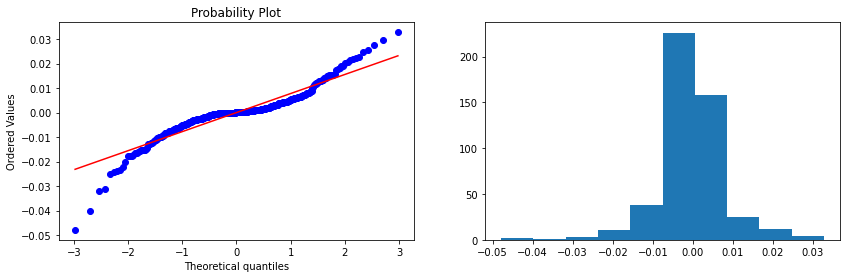

---------------------------------------------------------------------
|          Test            |    stat   |         p-value            |
---------------------------------------------------------------------
| Shapiro-Wilk Test        |   0.8825  |    1.2329560265948702e-18   |
| Anderson-Darling Test    |   19.5686  |             ----           |
| Breusch-Pagan Test       |  120.6085  |    1.4418212573486454e-18   |
| Bartlett Test            |  2297.4115 |   0.0   |
| Durbin-Watson Test       |    1.9124    |             ----           |
----------------------------------------------------------------------
Residuals do not look normal (reject H0)
Residuals do not look Homoscedasticity (reject H0)

****** Time ANOVA ******
                             sum_sq     df            F         PR(>F)
Technique                891.070144    3.0  5514.300328   0.000000e+00
Training_Test             46.127218    3.0   285.453772  5.940597e-105
Technique:Training_Test   55.863047    9.0   115.

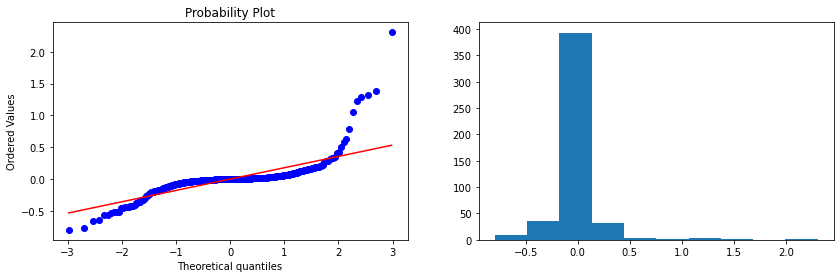

---------------------------------------------------------------------
|          Test            |    stat   |         p-value            |
---------------------------------------------------------------------
| Shapiro-Wilk Test        |   0.612  |    2.0445314469134506e-31   |
| Anderson-Darling Test    |   55.1748  |             ----           |
| Breusch-Pagan Test       |  37.713  |    0.0009946849482032271   |
| Bartlett Test            |  1133.6943 |   1.5693571185418313e-248   |
| Durbin-Watson Test       |    1.6102    |             ----           |
----------------------------------------------------------------------
Residuals do not look normal (reject H0)
Residuals do not look Homoscedasticity (reject H0)


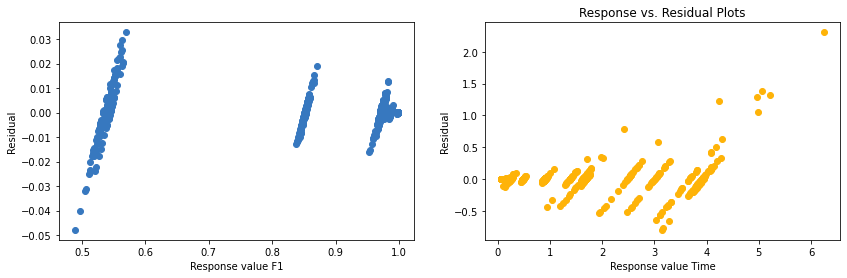


****** MANN-WHITNEY U NO PARAMETRIC TEST ******
Statistic =  14400.0  p-value =  6.922928874710724e-41
Different distribution (reject H0)

****** WILCOXON SIGNED-RANK NO PARAMETRIC TEST ******
Statistic =  0.0  p-value =  1.9719517121524354e-21
Different distribution (reject H0)

****** KRUSKAL NO PARAMETRIC TEST ******
Statistic =  179.3156089663014  p-value =  6.83678911938989e-41
Different distributions (reject H0)

****** FRIEDMAN NO PARAMETRIC TEST ******
Statistic =  236.0666666666666  p-value =  5.4799254801630274e-52
Different distributions (reject H0)


In [1]:
# ANOVA

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns

import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.formula.api import ols
from statsmodels.compat import lzip
import scipy.stats as sci

df = pd.read_csv("ident_outliers_all.csv",sep=",")

#print(df.dtypes)

# To convert datetime to float, time in seconds
new = df["Time_d"].str.split(":", n = -1, expand = True)
for i in range(new.shape[1]):
    new[i] = pd.to_numeric(new[i], errors='ignore')

df['Time'] = new[0]*3600 + new[1]*60 + new[2]
# End convertion

y = ['F1','Time']

y1 = df[y[0]]
y2 = df[y[1]]

res = pd.DataFrame()
for i in y:

	mod = ols(i+' ~ Technique + Training_Test + Technique:Training_Test', data=df).fit()

	aov_table = sm.stats.anova_lm(mod, typ=2)
	print("\n****** "+i+" ANOVA ******")
	print(aov_table)

	print("\n****** RESIDUALS ANALYSIS FOR "+i+" ******")
	# Plotting the Residuals
	res[i] = mod.resid
	fig = plt.figure(figsize=(14,4))
	ax1 = fig.add_subplot(121)
	ax2 = fig.add_subplot(122)

	sci.probplot(res[i], dist="norm", plot=ax1)
	plt.hist(res[i])
	plt.show()


	# normality test Shapiro-Wilk Test
	SW_stat, SW_p = sci.shapiro(res[i])
	#print('Shapiro-Wilk: Statistics=%.3f, p=%.3f' % (stat, p))



	# normality test Anderson-Darling Test
	AD_result = sci.anderson(res[i])
	#print('Anderson-Darling: Statistic: %.3f' % result.statistic)
	# p = 0
	# for i in range(len(result.critical_values)):
	# 	sl, cv = result.significance_level[i], result.critical_values[i]
	# 	if result.statistic < result.critical_values[i]:
	# 		print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
	# 	else:
	# 		print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

	# Residuals Homoscedasticity Breusch-Pagan Test
	names = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
	BP_test = sms.het_breuschpagan(res[i], mod.model.exog)
	lzip(names, BP_test)


	# Residuals Homoscedasticity Bartlett Test
	B_test = sci.bartlett(res[i], df[i].tolist())


	DW_test = sms.stattools.durbin_watson(res[i], axis=0)


	print("---------------------------------------------------------------------")
	print("|          Test            |    stat   |         p-value            |")
	print("---------------------------------------------------------------------")
	print("| Shapiro-Wilk Test        |  ",np.round(SW_stat,4)," |   ", SW_p,"  |")
	print("| Anderson-Darling Test    |  ",np.round(AD_result.statistic,4)," |             ----           |")
	print("| Breusch-Pagan Test       | ",np.round(BP_test[0],4)," |   ",BP_test[1],"  |")
	print("| Bartlett Test            | ",np.round(B_test[0],4),"|  ",B_test[1],"  |")
	print("| Durbin-Watson Test       |   ",np.round(DW_test,4),"   |             ----           |")
	print("----------------------------------------------------------------------")

	alpha = 0.05
	if SW_p > alpha:
		print('Residuals look normal (fail to reject H0)')
	else:
		print('Residuals do not look normal (reject H0)')

	if BP_test[1] > alpha:
		print('Residuals look Homoscedasticity (fail to reject H0)')
	else:
		print('Residuals do not look Homoscedasticity (reject H0)')


colors = sns.xkcd_palette(["windows blue", "amber", "faded green", "dusty purple","aqua blue"])

fig = plt.figure(figsize=(14,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

plt.title('Response vs. Residual Plots')

ax1.plot(df[y[0]],res[y[0]],'o',color=colors[0])
ax1.set_xlabel('Response value ' + str(y[0]))
ax1.set_ylabel('Residual')

ax2.plot(df[y[1]],res[y[1]],'o',color=colors[1])
ax2.set_xlabel('Response value ' + str(y[1]))
ax2.set_ylabel('Residual')

plt.show()


# *************** NO PARAMETRIC TESTS *************

d1 = df.loc[df.loc[:,"Technique"] == 'Autoencoder']
d2 = df.loc[df.loc[:,"Technique"] == 'HBOS']
d3 = df.loc[df.loc[:,"Technique"] == 'Percentile']
var_res = 'F1'

# Mann-Whitney U Test No parametric Test
print("\n****** MANN-WHITNEY U NO PARAMETRIC TEST ******")
stat, p = sci.mannwhitneyu(d1[var_res], d2[var_res])
print("Statistic = ",stat, " p-value = ", p)

alpha = 0.05
if p > alpha:
	print('Same distribution (fail to reject H0)')
else:
	print('Different distribution (reject H0)')


# Wilcoxon Signed-Rank No parametric Test
print("\n****** WILCOXON SIGNED-RANK NO PARAMETRIC TEST ******")
stat, p = sci.wilcoxon(d1[var_res], d2[var_res])
print("Statistic = ",stat, " p-value = ", p)

alpha = 0.05
if p > alpha:
	print('Same distribution (fail to reject H0)')
else:
	print('Different distribution (reject H0)')


# Kruskal-Wallis No parametric Test
print("\n****** KRUSKAL NO PARAMETRIC TEST ******")
stat, p = sci.kruskal(d1[var_res], d2[var_res])
print("Statistic = ",stat, " p-value = ", p)

alpha = 0.05
if p > alpha:
	print('Same distributions (fail to reject H0)')
else:
	print('Different distributions (reject H0)')

# Friedman Test No parametric Test
print("\n****** FRIEDMAN NO PARAMETRIC TEST ******")
stat, p = sci.friedmanchisquare(d1[var_res], d2[var_res], d3[var_res])
print("Statistic = ",stat, " p-value = ", p)

alpha = 0.05
if p > alpha:
	print('Same distributions (fail to reject H0)')
else:
	print('Different distributions (reject H0)')


# fig = plt.figure(figsize=(10,12))
# ax1 = fig.add_subplot(211)
# ax2 = fig.add_subplot(212)
# axes = [ax1,ax2]

# #resids = [r1, r2, r3]
# normed_resids = [res['F1']/df[y[0]], res['Time']/df[y[1]]]

# for (dataa, axx, colorr) in zip(normed_resids,axes,colors):
#     sns.kdeplot(dataa, bw=1.0, ax=axx, color=colorr, shade=True, alpha=0.5);

# ax1.set_title('Probability Distribution: Normalized Residual Error, y1')
# ax2.set_title('Normalized Residual Error, y2')

# plt.show()






The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


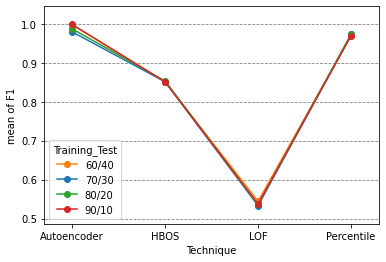

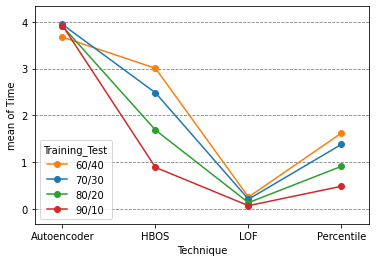

In [3]:
from statsmodels.graphics.factorplots import interaction_plot

fig, ax = plt.subplots()
ax.grid(axis='y', color='gray', linestyle='dashed')
fig = interaction_plot(
    x=df['Technique'],
    trace=df['Training_Test'],
    response=df['F1'],
    colors=[(255/256,127/256,14/256), (31/256,119/256,180/256), (44/256,160/256,44/256), (214/256,39/256,40/256)],
    markers=["o", "o", "o", "o"],
    #ms=10,
    ax=ax,
)
plt.savefig("F1.eps", dpi=200, bbox_inches='tight')



fig, ax = plt.subplots()
ax.grid(axis='y', color='gray', linestyle='dashed')
fig = interaction_plot(
    x=df['Technique'],
    trace=df['Training_Test'],
    response=df['Time'],
    colors=[(255/256,127/256,14/256), (31/256,119/256,180/256), (44/256,160/256,44/256), (214/256,39/256,40/256)],
    markers=["o", "o", "o", "o"],
    legendloc = 3,
    #ms=10,
    ax=ax,
)
plt.savefig("Dt.eps", dpi=200, bbox_inches='tight')
# fig, ax = plt.subplots(figsize=(16, 6))

# fig = interaction_plot(
#     x=df['Technique'],
#     trace=df['Training_Test'],
#     response=df['Time'],
#     colors=["red", "blue", "green"],
#     markers=["D", "^", "o"],
#     ms=10,
#     ax=ax,
# )



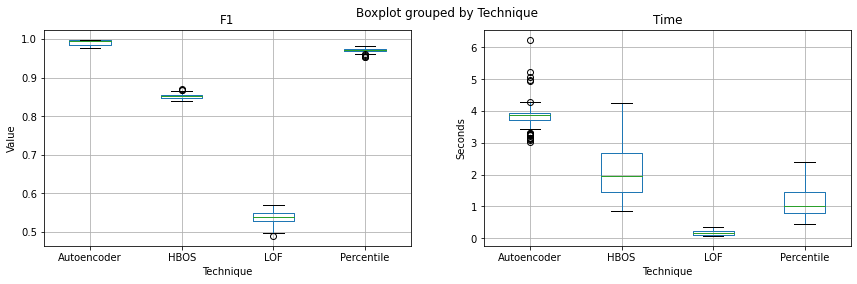

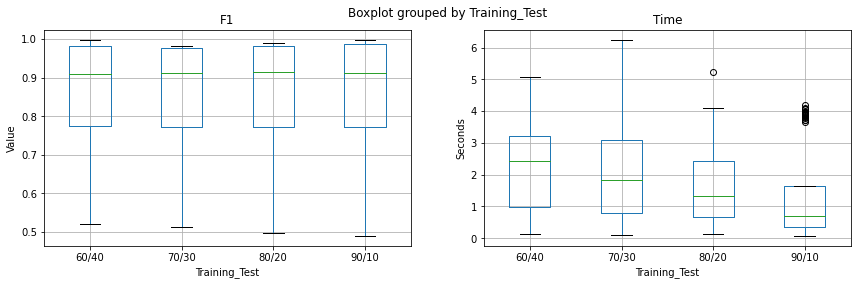

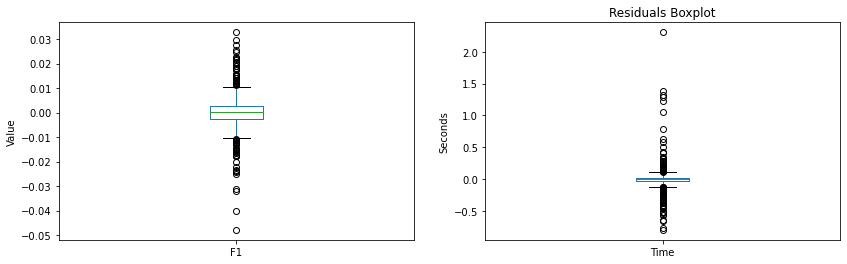

In [6]:
fig = plt.figure(figsize=(14,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

df.boxplot(column=['F1'], by='Technique', ax=ax1)
ax1.set_xlabel('Technique')
ax1.set_ylabel('Value')

df.boxplot(column=['Time'], by='Technique', ax=ax2)
ax2.set_xlabel('Technique')
ax2.set_ylabel('Seconds')

plt.show()

fig = plt.figure(figsize=(14,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

df.boxplot(column=['F1'], by='Training_Test', ax=ax1)
ax1.set_xlabel('Training_Test')
ax1.set_ylabel('Value')

df.boxplot(column=['Time'], by='Training_Test', ax=ax2)
ax2.set_xlabel('Training_Test')
ax2.set_ylabel('Seconds')

plt.show()

fig = plt.figure(figsize=(14,4))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

plt.title('Residuals Boxplot')

res.boxplot(column=['F1'], grid =False, ax=ax1)
ax1.set_ylabel('Value')

res.boxplot(column=['Time'], grid =False, ax=ax2)
ax2.set_ylabel('Seconds')

plt.show()



In [8]:
def compare(a, b):
    return '>' if a > b else '=' if a == b else '<'


'''
for var_res in ['F1','Time']:

    table1 = pd.DataFrame()
    table2 = pd.DataFrame()

    for tr in ['60/40','70/30','80/20']:
        a = df.loc[df.loc[:,"Training_Test"] == tr]
        ad1 = a.loc[a.loc[:,"Technique"] == 'Autoencoder']
        ad2 = a.loc[a.loc[:,"Technique"] == 'HBOS']
        ad3 = a.loc[a.loc[:,"Technique"] == 'Percentile']
        ad4 = a.loc[a.loc[:,"Technique"] == 'LOF']

        # Wilcoxon Signed-Rank No parametric Test
        table1 = table1.append({'':tr,
                                'A vs H': sci.wilcoxon(ad1[var_res], ad2[var_res])[1],
                                'A vs P': sci.wilcoxon(ad1[var_res], ad3[var_res])[1],
                                'A vs L': sci.wilcoxon(ad1[var_res], ad4[var_res])[1],
                                'H vs P': sci.wilcoxon(ad2[var_res], ad3[var_res])[1],
                                'H vs L': sci.wilcoxon(ad2[var_res], ad4[var_res])[1],
                                'L vs P': sci.wilcoxon(ad4[var_res], ad3[var_res])[1]},ignore_index=True)
        
        table2 = table2.append({'':tr,
                                'A vs H': compare(ad1[var_res].mean(),ad2[var_res].mean()),
                                'A vs P': compare(ad1[var_res].mean(),ad3[var_res].mean()),
                                'A vs L': compare(ad1[var_res].mean(),ad4[var_res].mean()),
                                'H vs P': compare(ad2[var_res].mean(),ad3[var_res].mean()),
                                'H vs L': compare(ad2[var_res].mean(),ad4[var_res].mean()),
                                'L vs P': compare(ad4[var_res].mean(),ad3[var_res].mean())},ignore_index=True)
    

    print('\n**** for',var_res,'******')
    print("\n****** WILCOXON SIGNED-RANK (p-value) ******\n",table1)
    print("\n****** PERFORMANCE ******\n",table2)
'''
for var_res in ['F1','Time']:

    table1 = pd.DataFrame({'':['A vs H', 'A vs P', 'A vs L', 'H vs P', 'H vs L', 'L vs P']})
    table2 = table1.copy()

    for tr in ['60/40','70/30','80/20', '90/10']:
        a = df.loc[df.loc[:,"Training_Test"] == tr]
        ad1 = a.loc[a.loc[:,"Technique"] == 'Autoencoder']
        ad2 = a.loc[a.loc[:,"Technique"] == 'HBOS']
        ad3 = a.loc[a.loc[:,"Technique"] == 'Percentile']
        ad4 = a.loc[a.loc[:,"Technique"] == 'LOF']

        # Wilcoxon Signed-Rank No parametric Test
        table1[tr] =    [sci.wilcoxon(ad1[var_res], ad2[var_res])[1],
                        sci.wilcoxon(ad1[var_res], ad3[var_res])[1],
                        sci.wilcoxon(ad1[var_res], ad4[var_res])[1],
                        sci.wilcoxon(ad2[var_res], ad3[var_res])[1],
                        sci.wilcoxon(ad2[var_res], ad4[var_res])[1],
                        sci.wilcoxon(ad4[var_res], ad3[var_res])[1]]
        
        table2[tr] =    [compare(ad1[var_res].mean(),ad2[var_res].mean()),
                        compare(ad1[var_res].mean(),ad3[var_res].mean()),
                        compare(ad1[var_res].mean(),ad4[var_res].mean()),
                        compare(ad2[var_res].mean(),ad3[var_res].mean()),
                        compare(ad2[var_res].mean(),ad4[var_res].mean()),
                        compare(ad4[var_res].mean(),ad3[var_res].mean())]
    

    print('\n**** for',var_res,'******')
    print("\n****** WILCOXON SIGNED-RANK (p-value) ******\n",table1)
    print("\n****** PERFORMANCE ******\n",table2)


**** for F1 ******

****** WILCOXON SIGNED-RANK (p-value) ******
               60/40     70/30     80/20     90/10
0  A vs H  0.000002  0.000002  0.000002  0.000002
1  A vs P  0.000002  0.000004  0.000002  0.000002
2  A vs L  0.000002  0.000002  0.000002  0.000002
3  H vs P  0.000002  0.000002  0.000002  0.000002
4  H vs L  0.000002  0.000002  0.000002  0.000002
5  L vs P  0.000002  0.000002  0.000002  0.000002

****** PERFORMANCE ******
           60/40 70/30 80/20 90/10
0  A vs H     >     >     >     >
1  A vs P     >     >     >     >
2  A vs L     >     >     >     >
3  H vs P     <     <     <     <
4  H vs L     >     >     >     >
5  L vs P     <     <     <     <

**** for Time ******

****** WILCOXON SIGNED-RANK (p-value) ******
               60/40     70/30     80/20     90/10
0  A vs H  0.000002  0.000002  0.000002  0.000002
1  A vs P  0.000002  0.000002  0.000002  0.000002
2  A vs L  0.000002  0.000002  0.000002  0.000002
3  H vs P  0.000002  0.000002  0.000002  0.00000

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


           Percentile   HBOS    LOF  Autoencoder
Precision       0.952  0.854  0.469        0.998
Recall          0.915  0.969  0.625        0.973
F1              0.933  0.908  0.536        0.986
Accuracy        0.986  0.980  0.897        0.997
Time            1.978  3.484  0.310        3.981


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


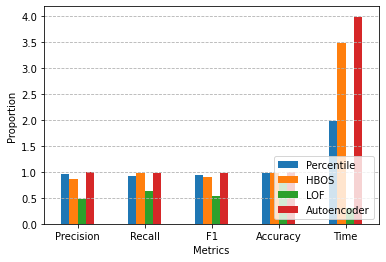

In [1]:
#Gráfico de las métricas de cada técnica

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import seaborn as sns
from statsmodels.graphics.factorplots import interaction_plot


datos = [[0.952, 0.854, 0.469, 0.998],
         [0.915, 0.969, 0.625, 0.973],
         [0.933, 0.908, 0.536, 0.986],
         [0.986, 0.980, 0.897, 0.997],
         [1.978, 3.484, 0.310, 3.981]]

#datos = [[0.996, 0.890, 0.495, 0.998],
#         [0.949, 0.810, 0.573, 0.973],
#         [0.972, 0.848, 0.531, 0.986],
#         [0.994, 0.971, 0.899, 0.997]]



time = [5.087, 5.864, 3.114, ]
columnas = ['Percentile', 'HBOS', 'LOF', 'Autoencoder'] # definimos los nombres de las columnas
filas = ['Precision', 'Recall', 'F1', 'Accuracy', 'Time'] # definimos los nombres de las filas

metricas = pd.DataFrame(datos, columns=columnas, index=filas)

print(metricas)

"""
fig, ax = plt.subplots()
dias = filas
temperaturas = {'HBOS':metricas['HBOS'].values, 'Autoencoder':metricas['Autoencoder'].values, 'Percentile':metricas['Percentile'].values}
ax.plot(dias, temperaturas['HBOS'], color = 'tab:purple', label = 'HBOS')
ax.plot(dias, temperaturas['Autoencoder'], color = 'tab:green', label = 'Autoencoder')
ax.plot(dias, temperaturas['Percentile'], color = 'tab:red', label = 'Percentile')
ax.grid(axis='y', color='gray', linestyle='dashed')
ax.set_xlabel('Metrics')
ax.set_ylabel('Percentage')
ax.legend()
plt.show()


fig, ax = plt.subplots()

metricas.plot(ax = ax, marker = 'o')
ax.hist(axis='y', color='gray', linestyle='dashed')
ax.set_xlabel('Metrics')
ax.set_ylabel('Percentage')
plt.savefig("Metrics_results.svg", dpi=200, bbox_inches='tight')
plt.show()
"""

ax = metricas.plot.bar(rot=0)
ax.grid(axis='y', linestyle='dashed')
ax.set_ylabel('Proportion')
ax.set_xlabel('Metrics')
ax.legend(loc='lower right')
plt.savefig("Metrics_results.eps", dpi=200, bbox_inches='tight')

 
 